# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed, Input
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNGRU, CuDNNLSTM, Conv2D, MaxPooling2D, Reshape
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.normalization import BatchNormalization
from keras.models import Model


from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
sns.set()

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load data

In [3]:
%pwd

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [4]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [5]:
df.head()

,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1


# Preprocessing
Prepare the data for the used model.

In [6]:
data = df.copy()

## Datetime info to categorical
Certain functions are able to use the Pandas categorical datatype, e.g. they don't require the feautures to be one-hot encoded.  

In [7]:
columns_to_category = ['hour', 'dayofweek', 'season']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# One hot encoding // dummy variables
One hot encode the categorical feautures.

In [8]:
#data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head()

,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1


# Adding a copy of the target column
This is because the `df_cnn_rnn_format()` function removes the target from the train dataset.  
The copy functions as the historical gasPower, just like ePower.

In [9]:
data['gasPower_copy'] = data['gasPower']
data.head()

,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season,gasPower_copy
datetime,,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1,6.115723
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1,5.238647
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1,2.451172
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1,3.065186
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1,8.120117


# Preprocessing, data to CNN format
Setting the `look_back`, `test_size` and some other parameters.  
Remember how the `df_to_lstm_rnn_format()` function splits the data into train & test and also has the ability to scale the X data per column.

In [10]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
train_size = 0.7

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=data, train_size=train_size, look_back=look_back, target_column='gasPower', scale_X=True)

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Taking a look of the train shape.  
There are (number of samples, rows, columns)

In [11]:
X_train.shape

(4326, 120, 8)

# Visualization of the train & test set target values

# The complete dataset

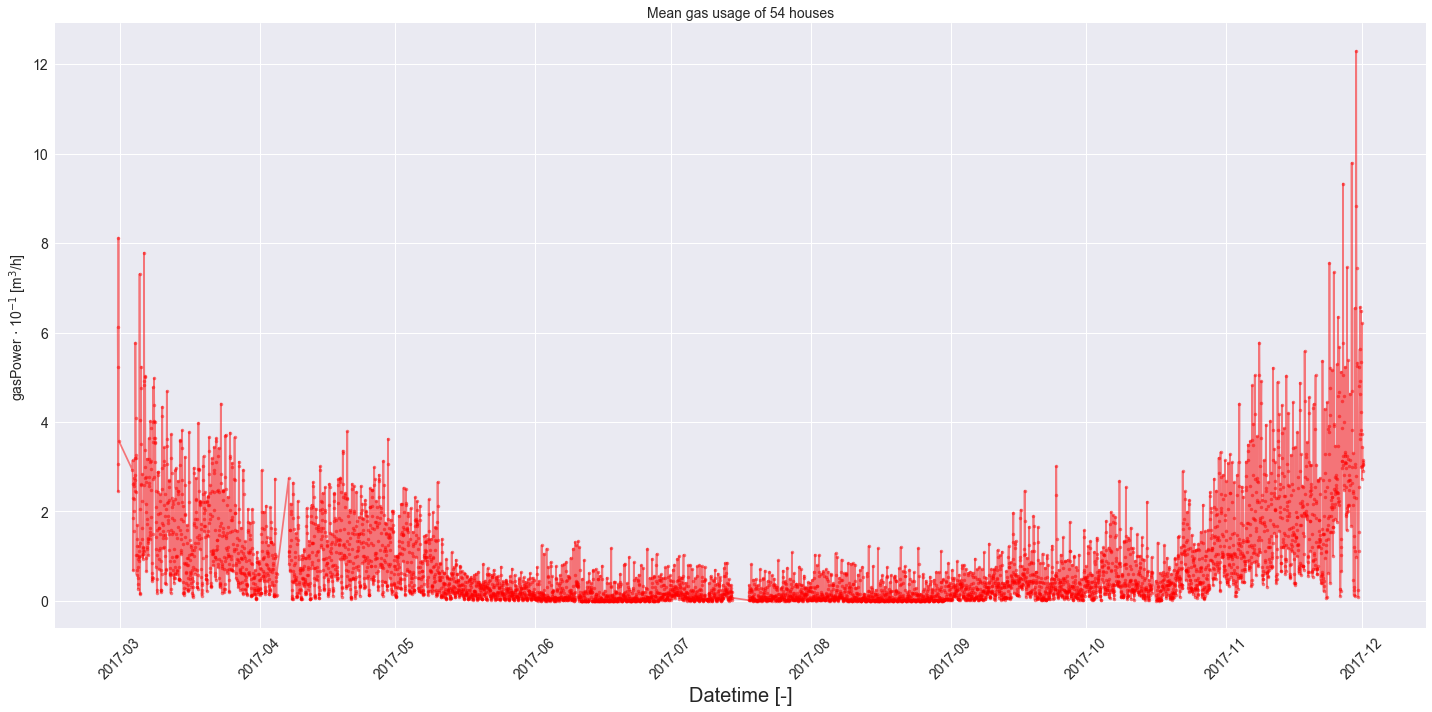

In [12]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Mean gas usage of 54 houses', fontsize=14)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# The train & test set

`TODO: Fix te look_back time difference.`  
For example, when loockback is 120 days, X_train length will be 4446 and y_train 4326...  
y_train is 120 shorter than X_train because the first 120 y values cannot be predicted due there not being 120 historical X values...  
So in the plots below there might be a 120 hour datetime difference with the actual datetime.  

In [13]:
"""
Get the X_train and X_test datetime values
"""
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

In [14]:
X_train_values.shape, y_train.shape

((4446, 9), (4326,))

In [15]:
X_test_values.shape, y_test.shape

((1906, 9), (1786,))

Temporary fix for the datetime length difference.

In [16]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((1786, 9), (1786,))

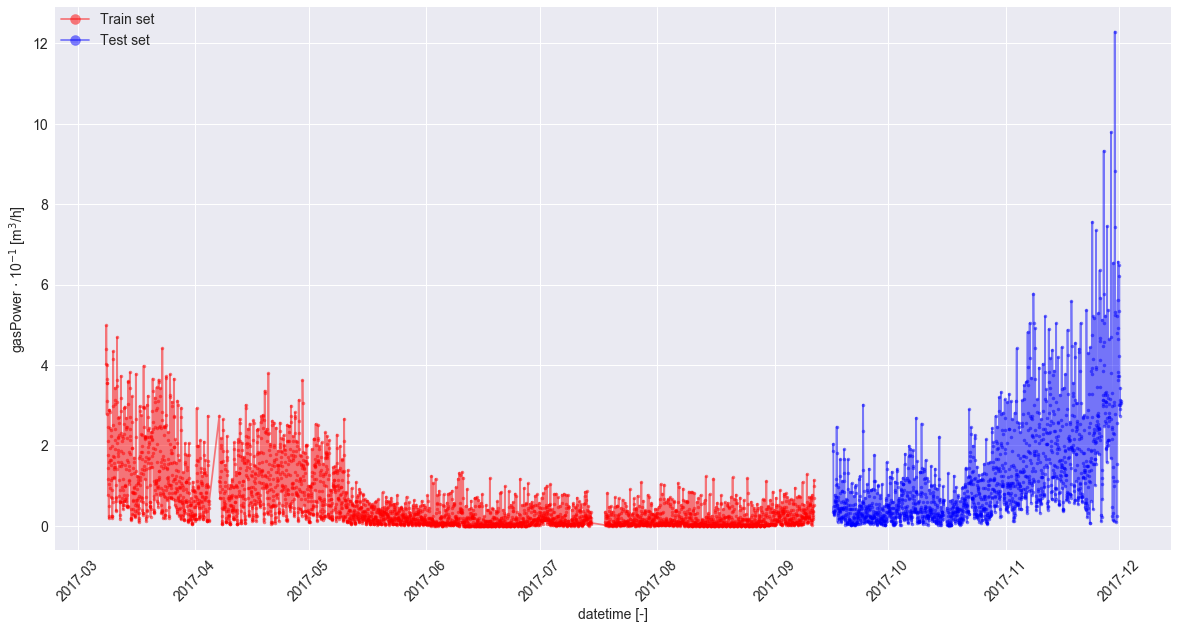

In [17]:
"""
Create the plot
"""
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

Notice that in the CNN notebook the channel dimension is added at this point.  
In this notebook this will be done after the `main_input` layer.

In [18]:
X_train.shape

(4326, 120, 8)

# Use float32 (FP32) training instead of float64 (FP64)
`TODO: Create a pipeline to which multiple CPU threads to feed data to the VRAM or force the date into the VRAM.` see [link](https://blog.metaflow.fr/tensorflow-how-to-optimise-your-input-pipeline-with-queues-and-multi-threading-e7c3874157e0).  
`Currently the CPU is bottlenecking.  `  
`GPU takes 202 us per epoch, but getting one epoch done takes ~1 s...`  

Lower float should equal less accurate numbers*, but in theory it should also speed up the GPU training.  
For more information see [this](https://www.kaggle.com/danmoller/keras-training-with-float16-test-kernel-2) notebook on Kaggle.  
Currently this is just a tryout, to see if the same accuracy can be received with a speed up in time per epoch taken.

*float64 uses 64 bit numbers whereas float32 uses 32 bit.

# CNN Model

In [45]:
cnn = Sequential() # This model is supposed to look at single images

cnn.add(Conv2D(
        filters=16,
        kernel_size=(2, 2),
        padding='same', kernel_initializer='TruncatedNormal'))
cnn.add(LeakyReLU())
cnn.add(BatchNormalization())

#cnn.add(MaxPooling2D(pool_size=(2, 2))) # Increases training speed by 2.5 times!

cnn.add(Flatten())

# RNN Model

In [46]:
dropout = 0.2
seed = 42

rnn = Sequential()

rnn.add(CuDNNGRU(512, return_sequences=False, kernel_initializer='TruncatedNormal')) #512
rnn.add(LeakyReLU())
rnn.add(Dropout(dropout, seed=seed))

# DNN Model

In [47]:
dnn = Sequential()
dnn.add(Dense(128, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(64, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

dnn.add(Dense(16, kernel_initializer='TruncatedNormal'))
dnn.add(LeakyReLU())
dnn.add(Dropout(dropout, seed=seed))

# output
dnn.add(Dense(1))

# Put it all together
Use the Keras functional API to for the models together.

In [48]:
main_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # Data has been reshaped to (800, 5, 120, 60, 1)
reshaped_to_smaller_images = Reshape(target_shape=(24, 5, X_train.shape[2], 1))(main_input)

model = TimeDistributed(cnn)(reshaped_to_smaller_images) # this should make the cnn 'run' 5 times?
model = rnn(model) # combine timedistributed cnn with rnn
model = dnn(model) # add dense

# Final model
Create the model, specify the input and output.

In [49]:
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 9)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 24, 5, 9, 1)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 720)           144       
_________________________________________________________________
sequential_5 (Sequential)    (None, 512)               1895424   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 76065     
Total params: 1,971,633
Trainable params: 1,971,601
Non-trainable params: 32
_________________________________________________________________


# Compile the model
Also set some hyperparameters like the learning rate (lr), amount of epochs and the batch size (bs).

In [50]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 5000
bs = 2**10  #11
lr = 6e-4 #6e-4
print(bs)

1024


In [51]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
final_model.compile(optimizer=nadam, loss = ['mse'], metrics=[mape, smape, 'mse'])

# Fit the model

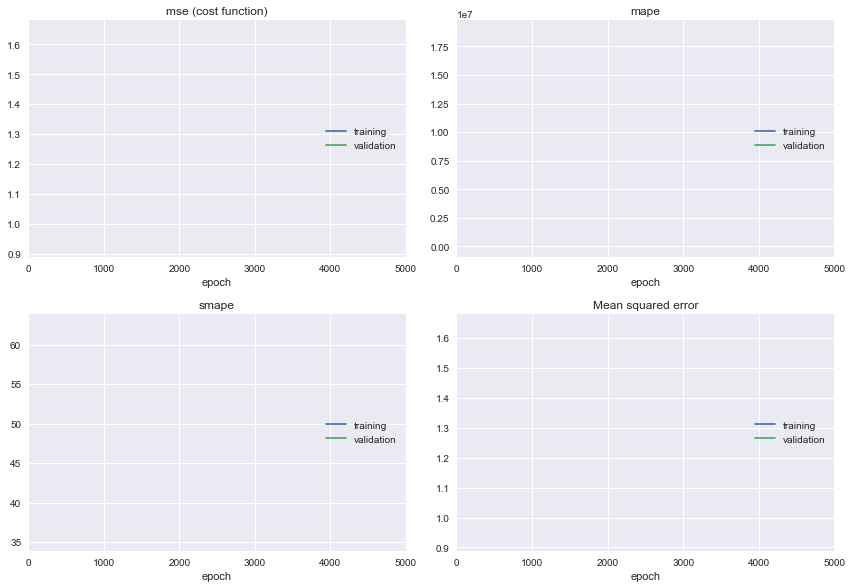

mse (cost function):
training   (min:    0.925, max:    0.925, cur:    0.925)
validation (min:    1.644, max:    1.644, cur:    1.644)

mape:
training   (min: 18839314.216, max: 18839314.216, cur: 18839314.216)
validation (min:  126.445, max:  126.445, cur:  126.445)

smape:
training   (min:   62.510, max:   62.510, cur:   62.510)
validation (min:   35.246, max:   35.246, cur:   35.246)

Mean squared error:
training   (min:    0.925, max:    0.925, cur:    0.925)
validation (min:    1.644, max:    1.644, cur:    1.644)

Epoch 00001: val_mape improved from inf to 126.44525, saving model to models\Opschaler.best_mape.hdf5

Epoch 00001: val_loss improved from inf to 1.64390, saving model to models\Opschaler.best_mse.hdf5

Epoch 00001: val_smape improved from inf to 35.24588, saving model to models\Opschaler.best_smape.hdf5
Epoch 2/5000
4326/4326 [==============================] - 2s 403us/step - loss: 0.3445 - mape: 126.1850 - smape: 43.5371 - mean_squared_error: 0.3445 - val_loss: 1.6551

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5000)

# This is used to save the best model, currently monitoring val_mape
# checkpoint


checkpoint1 = ModelCheckpoint("models\\Opschaler.best_mape.hdf5", monitor='val_mape', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint("models\\Opschaler.best_mse.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint("models\\Opschaler.best_smape.hdf5", monitor='val_smape', verbose=1, save_best_only=True, mode='min')

epoch_size = 5
schedule = SGDRScheduler(min_lr=1e-5, #1e-5
                                     max_lr=1e-2, # 1e-2
                                     steps_per_epoch=np.ceil(epoch_size/bs), 
                                     lr_decay=0.9,
                                     cycle_length=5, # 5
                                     mult_factor=1.5)

final_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[PlotLossesKeras(), checkpoint1, checkpoint2, checkpoint3, schedule])

print(final_model.summary())

# Load the saved model

In [ ]:
%time
from keras.models import load_model

# Load the architecture
model = load_model('models\\Opschaler.best_mape.hdf5', custom_objects={'smape': smape, 
                                                    'mape': mape}) # Gave an error when loading without 'custom_objects'.. fixed by https://github.com/keras-team/keras/issues/3911

# Compile with the same settings as it has been saved with earlier
model.compile(loss='mse', metrics=[mape, smape], optimizer=nadam)

print('FINISHED')

# Cross validate on the test set

In [ ]:
y_pred = final_model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result, _ = final_model.evaluate(X_test, y_test)

plt.title('CNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Downsample these results to a day

In [ ]:
# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_pred) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])


# Save the model results for later usage
result.to_csv('models\\Opschaler_predictions.csv')


result = result.resample('D').sum() # Resample data

result = result.dropna()

In [ ]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)
    

# Recalculated the metrics for the downsampled results
mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

In [ ]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('Opschaler result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)

# Downsample the hourly predictions

# Day

In [ ]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1D', model_name='...', savefig=False)

# Week

In [ ]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1W', model_name='...', savefig=False)

# 4 Weeks

In [4]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='4W', model_name='...', savefig=False)

NameError: name 'downsample_results' is not defined